In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

## 0. Load data

In [2]:
data_2018 = pd.read_csv('ks-projects-201801.csv', encoding = "ISO-8859-1")
data_2018.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


## 1. Clean data

In [3]:
# Remove white space in columns names
data_2018.columns = [col.strip() for col in data_2018.columns]

In [4]:
n_missing_values = data_2018.isnull().sum().sum() 
print(f'There are {n_missing_values} missing values in the original dataset.')
print("That represents {:.4f} % of the original data.".format(n_missing_values/(data_2018.shape[0]*data_2018.shape[1]) * 100))
columns_with_missing_values = data_2018.isnull().sum(axis=0).loc[lambda total: total > 0].keys().tolist()
print(f"There are {len(columns_with_missing_values)} columns with a least one missing values and those columns are : {', '.join(columns_with_missing_values)}")

There are 3801 missing values in the original dataset.
That represents 0.0669 % of the original data.
There are 2 columns with a least one missing values and those columns are : name, usd pledged


In [5]:
def clean_data(df):
    """Clean the dataframe"""
    
    # Drop rows with outlier values
    df = df[df.state != 'undefined']
    df = df[df.country != 'N,0"']
    
    # Drop rows that don't have a value for name
    df = df.dropna(subset=['name'], axis=0)  
    
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    fill_mean = lambda col: col.fillna(col.mean())
    
    # Impute missing numerical values with the mean of the column
    df[numeric_columns] = df[numeric_columns].apply(fill_mean, axis=0)
    
    return df 

In [113]:
cleaned_2018_data = clean_data(data_2018)

In [114]:
# Assert that there are no more missing values in the dataset
assert cleaned_2018_data.isnull().sum().sum() == 0

## 2. Assess data

In [8]:
data_2018.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


In [9]:
def plot_state_values(df):
    """Make a count plot of the state values"""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
    sns.countplot(df['state'])
    ax.set_title('State of 2018 projects on Kickstarter', fontsize=20)
    ax.set_xlabel("State", fontsize=15)
    ax.set_ylabel("Count", fontsize=15)

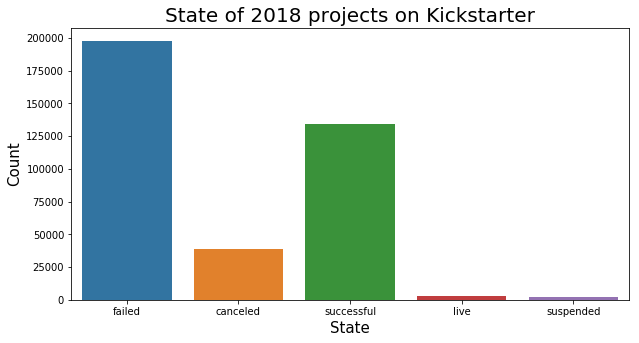

In [10]:
plot_state_values(cleaned_2018_data)

In [103]:
successful_projects = cleaned_2018_data[cleaned_2018_data['state'] == 'successful']

In [12]:
def plot_successful_projects(attribute, attribute_title):
    """Make a countplot of the successful projects for a specified attribute"""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
    sns.countplot(successful_projects[attribute])
    plt.xticks(rotation=45)
    ax.set_title(f'Sucessful 2018 projects by {attribute_title}', fontsize=20)
    ax.set_xlabel(attribute_title.capitalize(), fontsize=15)
    ax.set_ylabel("Count", fontsize=15)

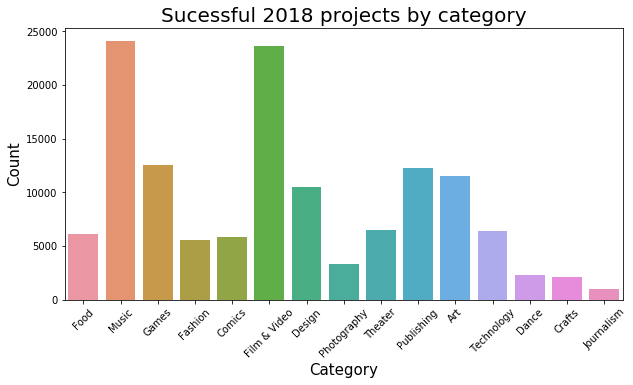

In [13]:
plot_successful_projects('main_category', 'category')

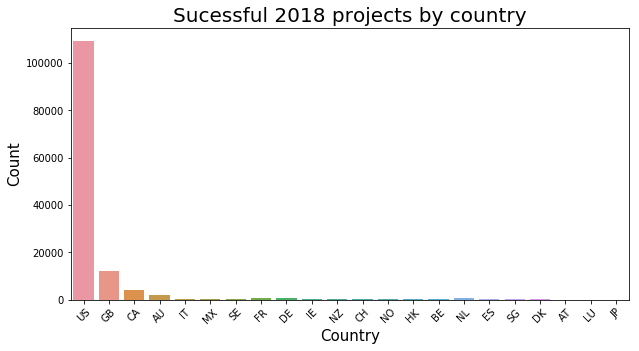

In [14]:
plot_successful_projects('country', 'country')

### 2.1 What is the probability of success for a kickstarter project ?

In [115]:
cleaned_2018_data['successful'] = (cleaned_2018_data['state'] == 'successful') * 1.0

In [16]:
percentage_of_success = cleaned_2018_data['successful'].mean() 
print("The probability of success for a 2018 kickstarter project is {:.4f} %".format(percentage_of_success * 100))

The probability of success for a 2018 kickstarter project is 35.7069 %


In [17]:
def plot_successful_projects_prob(attribute, attribute_title, palette="husl"):
    """Make a plot of the probability of success of a project for a specified attribute"""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
    s = cleaned_2018_data.groupby(attribute)['successful'].mean().sort_values()
    df = pd.DataFrame({attribute: s.index, '% of success': s.values})
    p1 = sns.barplot(x=attribute, y='% of success', data=df, palette=palette)
    plt.xticks(rotation=45)
    ax.axhline(y=percentage_of_success, color='black').set_linestyle('--')
    p1.text(3+0.2, percentage_of_success + 0.01, "Mean % of success", horizontalalignment='left', size='medium', color='black')
    ax.set_title(f'Probability of success by {attribute_title}', fontsize=20)
    ax.set_xlabel(attribute_title.capitalize(), fontsize=15)
    ax.set_ylabel("% of success", fontsize=15)

### 2.2 Which countries perform the best?

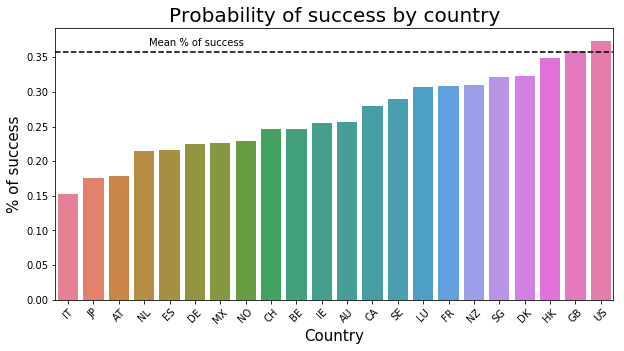

In [18]:
plot_successful_projects_prob('country', 'country')

### 2.3 Which categories of projects have the most chance to suceed ?

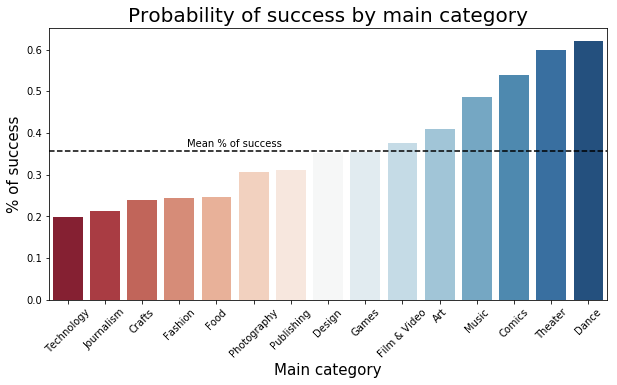

In [19]:
plot_successful_projects_prob('main_category', 'main category', palette="RdBu")

## 3. Data engineering

### 3.1 Do high goals lead to a higher degree of success ?

In [116]:
goal_map = {'very_low': 'Very low (between 0 and 25K)', 
            'low': 'Low (between 25K and 50K)', 
            'medium': 'Medium (between 50K and 100K)', 
            'high': 'High (between 100K and 200K)', 
            'very_high': 'Very high (Higher than 200K)'}

def rank_goal(val):
    """Rank the goal in USD in 5 different categories"""
    if val < 25000:
        return goal_map['very_low']
    elif val >= 25000 and val < 50000:
        return goal_map['low']
    elif val >= 50000 and val < 100000:
        return goal_map['medium']
    elif val >= 100000 and val < 200000:
        return goal_map['high']
    elif val >= 200000:
        return goal_map['very_high']
    else:
        raise ValueError(f'Bad value for {val}')
        
cleaned_2018_data['usd_goal_rank'] = cleaned_2018_data['usd_goal_real'].apply(rank_goal)

In [117]:
cleaned_2018_data['usd_goal_rank'].value_counts()

Very low (between 0 and 25K)     305271
Low (between 25K and 50K)         33329
Medium (between 50K and 100K)     20101
High (between 100K and 200K)       9000
Very high (Higher than 200K)       7159
Name: usd_goal_rank, dtype: int64

In [118]:
# Drop the column "usd_goal_real"
cleaned_2018_data = cleaned_2018_data.drop('usd_goal_real', axis=1)

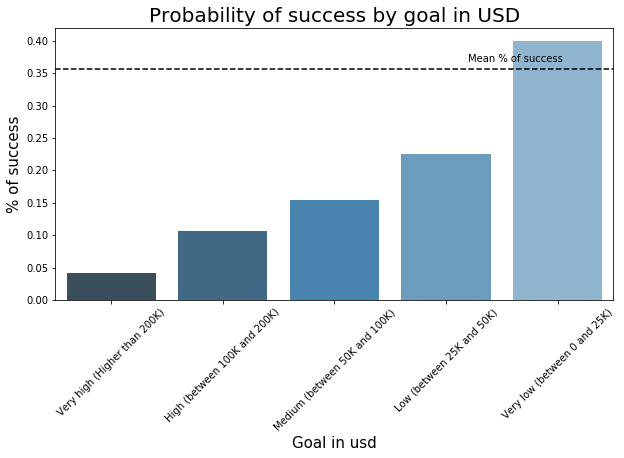

In [23]:
plot_successful_projects_prob('usd_goal_rank', 'goal in USD', palette="Blues_d")

### 3.2 Do long deadlines lead to more money pledged ?

In [119]:
cleaned_2018_data['deadline']=pd.to_datetime(cleaned_2018_data['deadline'])
cleaned_2018_data['launched']=pd.to_datetime(cleaned_2018_data['launched'])

In [120]:
cleaned_2018_data['time allowed (days)'] = (cleaned_2018_data['deadline'] - cleaned_2018_data['launched']).dt.days

In [121]:
# Drop the "deadline" and "launched" columns
cleaned_2018_data = cleaned_2018_data.drop('deadline', axis=1)
cleaned_2018_data = cleaned_2018_data.drop('launched', axis=1);

In [122]:
successfull_projects = cleaned_2018_data[cleaned_2018_data['successful'] == 1]

Text(0, 0.5, 'Pledged money (USD)')

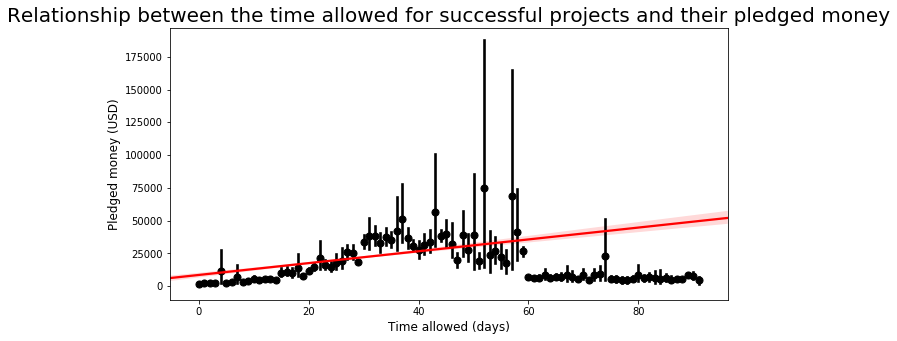

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
sns.regplot(x='time allowed (days)', y='usd_pledged_real', data=successfull_projects,
            x_estimator=np.mean, ci=95, scatter_kws={"color": "black"}, line_kws={"color": "red"})
ax.set_title('Relationship between the time allowed for successful projects and their pledged money', fontsize=20)
ax.set_xlabel("Time allowed (days)", fontsize=12)
ax.set_ylabel("Pledged money (USD)", fontsize=12)

### 3.3 Does the lenght of the project name has an influence on the pledged money ?

In [123]:
cleaned_2018_data['Name length'] = cleaned_2018_data['name'].apply(lambda name: len(name))

In [124]:
successfull_projects = cleaned_2018_data[cleaned_2018_data['successful'] == 1]

Text(0, 0.5, 'Pledged money (USD)')

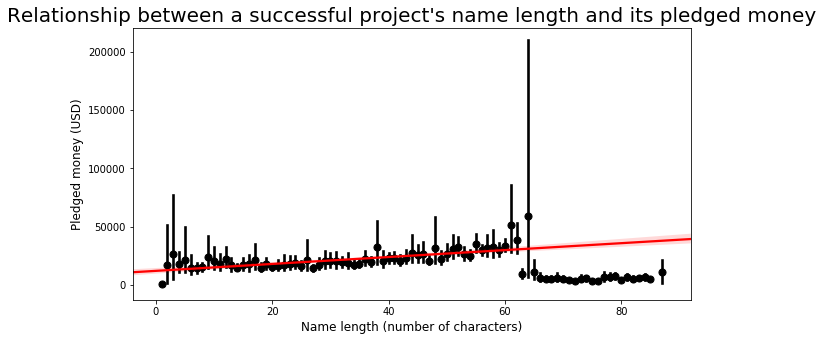

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
sns.regplot(x='Name length', y='usd_pledged_real', data=successfull_projects, 
            x_estimator=np.mean, ci=99, scatter_kws={"color": "black"}, line_kws={"color": "red"})
ax.set_title("Relationship between a successful project's name length and its pledged money", fontsize=20)
ax.set_xlabel("Name length (number of characters)", fontsize=12)
ax.set_ylabel("Pledged money (USD)", fontsize=12)

In [32]:
good_project_names = successfull_projects[(successfull_projects['Name length'] > 45)
                                          & (successfull_projects['Name length'] < 65)]

Seems that the best lenght for a project name is between 45 and 60. Here are a few examples of good project names:

In [33]:
good_project_names['name'].values[:10].tolist()

['Support Solar Roasted Coffee & Green Energy!  SolarCoffee.co',
 'Tombstone: Old West tabletop game and miniatures in 32mm.',
 'Matt Cavenaugh & Jenny Powers make their 1st album! ',
 'Rebel Army Origins: The Heroic Story Of Major Gripes',
 'Zen in America: a film on Zen Buddhism in North America',
 'Phil Younger - Slow Down (Official Music Video)',
 "I'LL SEE YOU IN MY DREAMS - narrative feature film",
 'Mothers Into Living Fit Yoga DVD for Moms and Babies',
 'Pantochino Productions: "Cinderella Skeleton, the Musical"',
 '"Little Shop of Horrors" at the Browncoat Theatre!']

## 4. Machine Learning

Let's create a machine learning model that hopefully can predict if a Kickstarter project will be succesful based on its characteristics.

In [125]:
cleaned_2018_data.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'goal',
       'pledged', 'state', 'backers', 'country', 'usd pledged',
       'usd_pledged_real', 'successful', 'usd_goal_rank',
       'time allowed (days)', 'Name length'],
      dtype='object')

First of all, let's drop the columns that we know they won't give useful information for our machine learning model or that we already engineered: 

In [126]:
cleaned_2018_data = cleaned_2018_data.drop(['ID', 'name'], axis=1)

Let's also drop the "pledged" and the "backers" columns, since knowing how much money the project received afterwards is kind of "cheating". In a real case scenario, we have to predict if a project will be successful before the funding begins.

In [127]:
cleaned_2018_data = cleaned_2018_data.drop(['usd_pledged_real', 'pledged', 'usd pledged', 'backers', 'state'], axis=1)

In [128]:
cleaned_2018_data.columns

Index(['category', 'main_category', 'currency', 'goal', 'country',
       'successful', 'usd_goal_rank', 'time allowed (days)', 'Name length'],
      dtype='object')

In [129]:
def dummy_cat_columns(df):
    """Get dummies for the categorical columns of our dataframe"""
    cat_columns = df.select_dtypes(include=['object']).columns.tolist()
    
    df = pd.get_dummies(df, prefix=cat_columns, drop_first=True)
    
    return df

In [130]:
def standardize_dataset(df):
    """Standardize the numeric columns of a dataset"""
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    scaler = StandardScaler()
    
    df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
    return df

In [131]:
X = dummy_cat_columns(cleaned_2018_data)

In [132]:
y = X['successful']
X = X.drop('successful', axis=1)

In [133]:
X = standardize_dataset(X)

c:\users\benjamin\anaconda3\envs\pytorch\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\benjamin\anaconda3\envs\pytorch\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [134]:
X.shape

(374860, 213)

In [135]:
# Make sure our dataset contains the same number of values as our labels dataset
assert X.shape[0] == y.shape[0]

## 4.1 Models comparaison

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [137]:
def train_and_test_model(model, X_train, X_test, y_train, y_test, print_time=True):
    """Train and test a machine learning model"""
    start = time.time()
    model = model.fit(X_train, y_train)
    end = time.time()
    if print_time:
        print(f'The model took {end - start} seconds to train.')
    
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    
    train_accuracy = accuracy_score(train_predictions, y_train)
    test_accuracy = accuracy_score(test_predictions, y_test)
    
    print(f'The train accuracy of the model is {train_accuracy}')
    print(f'The test accuracy of the model is {test_accuracy}')
    
    return model

In [138]:
random_state = 42

### 4.1.1 Logistic Regression

Let's start with a simple Logistic Regression model:

In [139]:
lr = LogisticRegression(random_state=random_state, solver='lbfgs');
train_and_test_model(lr, X_train, X_test, y_train, y_test);

c:\users\benjamin\anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


The model took 9.087703466415405 seconds to train.
The train accuracy of the model is 0.68867556419118
The test accuracy of the model is 0.6876414667270258


### 4.1.2 Decision Tree

In [140]:
dt = DecisionTreeClassifier(random_state=random_state);
train_and_test_model(dt, X_train, X_test, y_train, y_test);

The model took 9.137571811676025 seconds to train.
The train accuracy of the model is 0.9613148799949036
The test accuracy of the model is 0.627497898208627


We can see that the model performs well, but does a lot of overfitting. Regularizations techniques can be used to reduce that behaviour.

### 4.1.3 AdaBoost

In [141]:
adc = AdaBoostClassifier(random_state=random_state);
train_and_test_model(adc, X_train, X_test, y_train, y_test);

The model took 23.609883308410645 seconds to train.
The train accuracy of the model is 0.6935649556450971
The test accuracy of the model is 0.6928959451594128


### 4.1.4 Random Forest Classifier

In [142]:
rf = RandomForestClassifier(random_state=random_state, n_estimators=10);
train_and_test_model(rf, X_train, X_test, y_train, y_test);

The model took 9.720041036605835 seconds to train.
The train accuracy of the model is 0.9406942298810301
The test accuracy of the model is 0.6562843562051348


This model performs very well, bu like the Decision Tree Classifier, it does overfitting. Increasing the number of estimators will likely improve the accuracy of that model on the test data. This model is also pretty fast to train.

### 4.1.5 Gradient Boosting Classifier

In [143]:
gbc = GradientBoostingClassifier(random_state=random_state);
train_and_test_model(gbc, X_train, X_test, y_train, y_test);

The model took 114.48594570159912 seconds to train.
The train accuracy of the model is 0.6968776378027999
The test accuracy of the model is 0.6957737825777662


### 4.1.6 Voting Classifier

Let's try to se a voting classifier. That type of classifier uses multiples models, asks each of them to predict the value of a data point, and select the most popular one as its final prediction. We will use all of the above models as voters.

In [144]:
vc = VotingClassifier(estimators=[('lr', lr), ('dt', dt), ('adc', adc), ('rf', rf), ('gbc', gbc)]);
train_and_test_model(vc, X_train, X_test, y_train, y_test);

c:\users\benjamin\anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


The model took 158.21009063720703 seconds to train.
The train accuracy of the model is 0.7589545939575403
The test accuracy of the model is 0.6954180948069586


The voting classifier perfors well, but is obviously very slow to train since it combines the predictions of all the models. It is interesting to see that it performs better than all of the other models on the training dataset, but performs slightly less on the test dataset compared to the Gradient Boosting Classifier.

We decided to choose the **Adaboost** model, since it offers great performance while being relatively fast to train.

### 4.1.7 Hyperparameters tuning

In [146]:
parameters = {'n_estimators':[20, 30, 50, 100, 120, 150], 
              'learning_rate':[0.1, 0.2, 0.5, 0.7, 1.0], 
              'algorithm': ('SAMME', 'SAMME.R'),
              'random_state': [random_state]}

grid_object = GridSearchCV(adc, parameters, cv=3)
grid_object = train_and_test_model(grid_object, X_train, X_test, y_train, y_test, print_time=False);

The train accuracy of the model is 0.6980402618293013
The test accuracy of the model is 0.6967761753864062


In [147]:
best_model = grid_object.best_estimator_
best_model

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=150, random_state=42)

In [148]:
importances = best_model.feature_importances_

In [155]:
def feature_plot(importances, X_train, y_train, n_features):
    # Display the "n_features" most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:n_features]]
    values = importances[indices][:n_features]

    fig = plt.figure(figsize=(9, 7))
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize=16)
    plt.bar(np.arange(n_features), values, width=0.6, align="center", color='#00A000', label="Feature Weight")
    plt.bar(np.arange(n_features) - 0.3, np.cumsum(values), width=0.2, align="center", color='#00A0A0',
           label="Cumulative Feature Weight")
    plt.xticks(np.arange(n_features), columns, rotation=45)
    plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize=12)
    plt.xlabel("Feature", fontsize=12)

    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

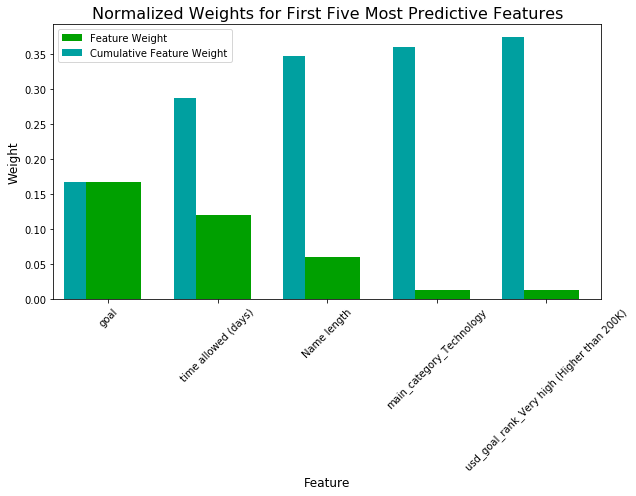

In [156]:
feature_plot(importances=importances, X_train=X_train, y_train=y_train, n_features=5)

In [157]:
indices = np.argsort(importances)[::-1]
columns = X_train.columns.values[indices]
values = importances[indices]

data = {'column': columns, 'importance': values}
df = pd.DataFrame(data=data)
df.head(20)

,column,importance
0,goal,0.166667
1,time allowed (days),0.120000
2,Name length,0.060000
3,main_category_Technology,0.013333
4,usd_goal_rank_Very high (Higher than 200K),0.013333
5,category_Metal,0.006667
6,category_Nonfiction,0.006667
7,category_Nature,0.006667
8,category_Narrative Film,0.006667
9,category_Mobile Games,0.006667
